<a href="https://colab.research.google.com/github/92kunheekim/EPACT/blob/main/EPACT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EPACT Tutorial Notebook on Google Colab
| [Preprint](https://www.biorxiv.org/content/10.1101/2024.04.05.588255v1) | [GitHub](https://github.com/zhangyumeng1sjtu/EPACT/) |

EPACT is developed by a divide-and-conquer paradigm that combines pre-training on TCR or pMHC data and transfer learning to predict TCR$\alpha\beta$-pMHC binding specificity and interaction conformation via epitope-anchored contrastive learning.

In [1]:
%%time
#@title Install EPACT and Download model checkpoints

# Clone the GitHub Repo and install dependencies.
!git clone https://github.com/zhangyumeng1sjtu/EPACT.git
%cd EPACT
# !pip -q install torch==2.0.1 --index-url https://download.pytorch.org/whl/cu117
!pip -q install -r requirements.txt

# Download model checkpoints and data
!mkdir checkpoints
!wget -O checkpoints/EPACT-model-checkpoints.zip https://zenodo.org/records/10996150/files/EPACT-model-checkpoints.zip?download=1
%cd checkpoints
!unzip EPACT-model-checkpoints.zip > /dev/null 2>&1
%cd ..

!mkdir data
!wget -O data/EPACT-data.zip https://zenodo.org/records/10996150/files/EPACT-data.zip?download=1
%cd data
!unzip EPACT-data.zip > /dev/null 2>&1
%cd ..

Cloning into 'EPACT'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 92 (delta 6), reused 5 (delta 5), pack-reused 82 (from 1)
Receiving objects: 100% (92/92), 1.72 MiB | 10.74 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/EPACT
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.9/757.9 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [12]:
! python scripts/predict/predict_pmhc_presentation.py \
--config configs/config-pmhc-elution.yml \
--input_data_path  \
--model_location  \
--log_dir log/el_test

Traceback (most recent call last):
  File "/content/EPACT/EPACT/../scripts/predict/predict_pmhc_presentation.py", line 6, in <module>
    from EPACT.utils import load_config, set_seed
ModuleNotFoundError: No module named 'EPACT'


In [18]:
from logging import log
import os

from torch.utils.data import DataLoader
from EPACT.utils import load_config, set_seed
from EPACT.dataset import UnlabeledDataset, UnlabeledBacthConverter
from EPACT.trainer import EpitopeMHCTrainer

model_location = 'checkpoints/pretrained/pmhc-EL-model-medium.pt'
log_dir = 'log/el_test'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

config_path = 'configs/config-pmhc-elution.yml'
config = load_config(config_path)
config
Trainer = EpitopeMHCTrainer(config, log_dir)

{'task': 'EL',
 'training': {'gpu_device': 0,
  'batch_size': 1024,
  'num_workers': 4,
  'seed': 42,
  'lr': 0.0001,
  'weight_decay': 0.01,
  'max_epochs': 50,
  'warm_epochs': 5,
  'patience': 10,
  'lr_scheduler': 'cosine',
  'lr_decay_steps': 50,
  'lr_decay_rate': 0.5,
  'lr_decay_min_lr': 1e-06,
  'lambda_factor': 0.05,
  'use_focal_loss': True,
  'pretrained_epitope_model': 'checkpoints/pretrained/epitope-model-medium.pt',
  'log_dir': 'logs/pretrained-pmhc-elution/v1/'},
 'model': {'num_epi_layers': 6,
  'num_epi_heads': 4,
  'embed_epi_dim': 512,
  'num_mhc_layers': 6,
  'in_mhc_dim': 45,
  'embed_mhc_dim': 256,
  'cross_attn_heads': 4,
  'mhc_seq_len': 366,
  'attn_dropout': 0.05,
  'dropout': 0.2},
 'data': {'data_path': 'data/pretrained/',
  'hla_lib_path': 'data/hla_library.json',
  'max_epi_len': 15}}

In [ ]:
input = pd.read_csv('/content/EPACT/data/sarkizova_2020_supplementary_data1.csv')
input.reset_index(drop=True, inplace=True)
input['pep'] = input['pep'].str.upper()

input.rename(columns={'mhc':'MHC','pep':'Epitope.peptide','tgt':'Target'}, inplace=True)
input.to_csv('/content/EPACT/data/sarkizova_2020_supplementary_data1_rename.csv')

input_data_path = '/content/EPACT/data/sarkizova_2020_supplementary_data1_rename.csv'
dataset = UnlabeledDataset(data_path = input_data_path, hla_lib_path = config.data.hla_lib_path, mhc_pseudo_pos = None)

data_loader = DataLoader(dataset = dataset, shuffle = False, batch_size = config.training.batch_size, num_workers = config.training.num_workers,
                         collate_fn = UnlabeledBacthConverter(max_mhc_len = config.model.mhc_seq_len),)
Trainer.predict(data_loader, model_location=model_location)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/content/EPACT/EPACT/trainer/binding_trainer.py:193: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

In [52]:
df = pd.read_csv(f'{log_dir}/predictions.csv')
df.reset_index(drop=True, inplace=True)
input['EPACT'] = df['Pred']
input.head()

(946001, 13)
(946001, 2)


,index,MHC,Epitope.peptide,Target,NetMHCpan-4.1_Scores,NetMHCpan-4.1_Ranks,MHCnuggets-2.4.0,MixMHCpred-2.1_Scores,MixMHCpred-2.1_Ranks,TransPHLA,BigMHC_Ablation_Canonical_LSTM_EL,BigMHC_Ablation_Wide_LSTM_EL,BigMHC_EL,Pred
0,0,HLA-A*02:02,AAAAAAAAESEAE,0,0.0000,85.0000,0.100180,-0.668379,67.0,0.3541,0.000194,0.000026,0.000123,0.021533
1,1,HLA-A*02:02,AAAAAAAEEEE,0,0.0000,68.8462,0.089923,-0.765002,80.0,-4.3787,0.000079,0.000027,0.000087,0.008430
2,2,HLA-A*02:02,AAAAAAAGVPVG,0,0.0000,77.1429,0.140768,-0.677126,69.0,-0.9964,0.000128,0.000090,0.000110,0.017324
3,3,HLA-A*02:02,AAAAAAAK,0,0.0000,69.6154,0.021924,-0.776820,81.0,-5.0699,0.000321,0.000059,0.000074,0.002767
4,4,HLA-A*02:02,AAAAAGTGQA,0,0.0013,23.4929,0.118457,-0.595463,57.0,-6.6617,0.000028,0.000074,0.000062,0.006029


In [36]:
input.rename(columns={'MHC': 'mhc','Epitope.peptide':'pep','Target':'tgt'}, inplace=True)
input = input.drop('index', axis=1)
input.rename(columns={'Pred': 'EPACT'}, inplace=True)
print(input.head())
input.to_csv('/content/EPACT/log/el_test/el_test_out.csv', index=False)

           mhc            pep  tgt  NetMHCpan-4.1_Scores  NetMHCpan-4.1_Ranks  \
0  HLA-A*02:02  AAAAAAAAESEAE    0                0.0000              85.0000   
1  HLA-A*02:02    AAAAAAAEEEE    0                0.0000              68.8462   
2  HLA-A*02:02   AAAAAAAGVPVG    0                0.0000              77.1429   
3  HLA-A*02:02       AAAAAAAK    0                0.0000              69.6154   
4  HLA-A*02:02     AAAAAGTGQA    0                0.0013              23.4929   

   MHCnuggets-2.4.0  MixMHCpred-2.1_Scores  MixMHCpred-2.1_Ranks  TransPHLA  \
0          0.100180              -0.668379                  67.0     0.3541   
1          0.089923              -0.765002                  80.0    -4.3787   
2          0.140768              -0.677126                  69.0    -0.9964   
3          0.021924              -0.776820                  81.0    -5.0699   
4          0.118457              -0.595463                  57.0    -6.6617   

   BigMHC_Ablation_Canonical_LSTM_EL  

<Axes: xlabel='EPACT', ylabel='Count'>

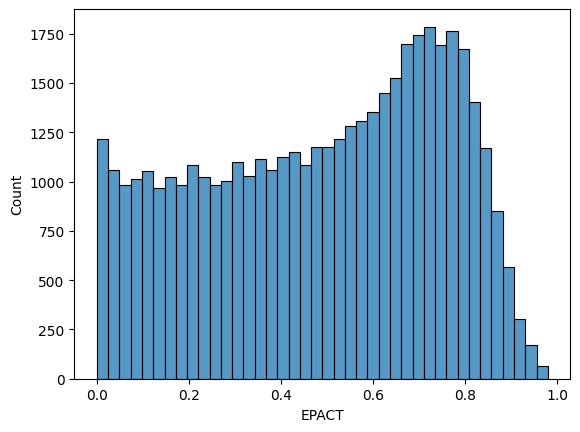

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

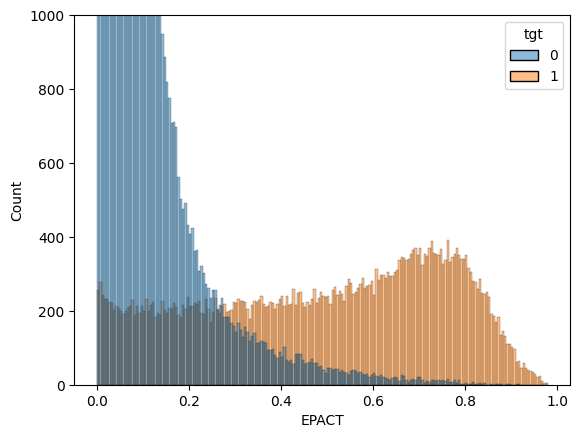

In [45]:
ax = sns.histplot(input, x='EPACT', hue='tgt', binwidth=0.005)
ax.set_ylim(0,1000)
plt.show()
plt.close()

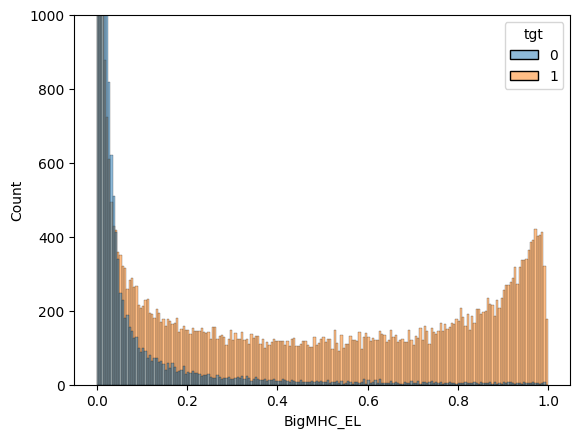

In [46]:
ax = sns.histplot(input, x='BigMHC_EL', hue='tgt', binwidth=0.005)
ax.set_ylim(0,1000)
plt.show()
plt.close()

## Predict Paired TCR-pMHC binding specificity.

Input Data Format: CSV files containing CDR3 (CDR1, CDR2) and Epitope sequences and MHC alleles.

| CDR3.alpha.aa | CDR3.beta.aa | Epitope.peptide | MHC | CDR1.alpha.aa | CDR2.alpha.aa | CDR1.beta.aa | CDR2.beta.aa |
|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|
| CAESVGKLIF | CSVGSQGTNEKLFF | GLCTLVAML | HLA-A*02:01 | DSSSTY | IFSNMDM | SQVTM | ANQGSEA |
|...|...|...|...|...|...|...|...|
| CVVNSINDYKLSF |CASSLTLQRVGTGELFF |  GLCTLVAML | HLA-A*02:01 | NSASQS | VYSSGN | SGHTA | FQGNSA |

Model Options:
  - `checkpoints/paired-cdr3-pmhc-binding`: predict TCR$\alpha\beta$-pMHC binding specificity from CDR3 sequences.
  - `checkpoints/paired-cdr123-pmhc-binding`: predict TCR$\alpha\beta$-pMHC binding specificity from CDR1, CDR2, and CDR3 sequences.



In [ ]:
#@title Run prediction

import os

from torch.utils.data import DataLoader
from EPACT.utils import load_config, set_seed
from EPACT.dataset import UnlabeledDataset, UnlabeledBacthConverter
from EPACT.trainer import PairedCDR3pMHCCoembeddingTrainer, PairedCDR123pMHCCoembeddingTrainer

#@markdown Select the EPACT model:
model_name = "CDR123 binding model" #@param ['CDR3 binding model', 'CDR123 binding model']

#@markdown In default, we will use `sample/VDJdb-GLCTLVAML.csv` for prediction.
input_data_path = "sample/VDJdb-GLCTLVAML.csv" #@param {type:"string"}

#@markdown Specify the name of the result folder:
result_dir = "demo/binding" #@param {type:"string"}

#@markdown Specify the number of batch size:
batch_size = 128 #@param {type: "integer"}


if model_name == "CDR3 binding model":
  config_path = 'configs/config-paired-cdr3-pmhc-binding.yml'
  model_location_list = [f'checkpoints/paired-cdr3-pmhc-binding/paired-cdr3-pmhc-binding-model-fold-{i+1}.pt' for i in range(5)]
elif model_name == "CDR123 binding model":
  config_path = 'configs/config-paired-cdr123-pmhc-binding.yml'
  model_location_list = [f'checkpoints/paired-cdr123-pmhc-binding/paired-cdr123-pmhc-binding-model-fold-{i+1}.pt' for i in range(5)]

config = load_config(config_path)
set_seed(config.training.seed)
config.training.gpu_device = 0


dataset = UnlabeledDataset(data_path = input_data_path, hla_lib_path = config.data.hla_lib_path)
data_loader = DataLoader(
        dataset = dataset, batch_size = batch_size, num_workers = 1,
        collate_fn = UnlabeledBacthConverter(max_mhc_len = config.model.mhc_seq_len, use_cdr123=config.data.use_cdr123),
        shuffle = False
    )

if not os.path.exists(result_dir):
  os.makedirs(result_dir)

for i in range(5):
  result_fold_dir = os.path.join(result_dir, f'Fold_{i+1}')

  if not os.path.exists(result_fold_dir):
    os.makedirs(result_fold_dir)

  if config.data.use_cdr123:
      Trainer = PairedCDR123pMHCCoembeddingTrainer(config, result_fold_dir)
  else:
      Trainer = PairedCDR3pMHCCoembeddingTrainer(config, result_fold_dir)

  Trainer.predict(data_loader, model_location=model_location_list[i])


  0%|          | 0/2 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 0/2 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 0/2 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 2/2 [00:00<00:00,  3.83it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and J

In [ ]:
#@title Display prediction results
import pandas as pd

data = pd.read_csv(input_data_path)
for i in range(5):
  prediction = pd.read_csv(f'{result_dir}/Fold_{i+1}/predictions.csv')
  if i == 0:
    avg_pred = prediction['Pred'] / 5
  else:
    avg_pred += prediction['Pred'] / 5

data['Pred'] = avg_pred
data

,CDR3.alpha.aa,CDR3.beta.aa,Epitope.peptide,MHC,V.alpha,J.alpha,V.beta,J.beta,CDR1.alpha.aa,CDR2.alpha.aa,CDR1.beta.aa,CDR2.beta.aa,Target,Pred
0,CAESVGKLIF,CSVGSQGTNEKLFF,GLCTLVAML,HLA-A*02:01,TRAV5,TRAJ23,TRBV29-1,TRBJ1-4,DSSSTY,IFSNMDM,SQVTM,ANQGSEA,1,0.807142
1,CAFVANAGGTSYGKLTF,CASSYTRVNEQFF,GLCTLVAML,HLA-A*02:01,TRAV38-1,TRAJ52,TRBV6-9,TRBJ2-1,TSENNYY,QEAYKQQN,MNHGY,SVAAGI,1,0.020218
2,CAGNNARLVF,CASSQSPGGTQYF,GLCTLVAML,HLA-A*02:01,TRAV27,TRAJ31,TRBV14,TRBJ2-5,SVFSS,VVTGGEV,SGHDN,FVKESK,1,0.016683
3,CAGNNARPMF,CASSQSPGGVAFF,GLCTLVAML,HLA-A*02:01,TRAV27,TRAJ31,TRBV14,TRBJ1-1,SVFSS,VVTGGEV,SGHDN,FVKESK,1,0.009218
4,CALDILYNQGGKLIF,CASSQSPGGTQYF,GLCTLVAML,HLA-A*02:01,TRAV6,TRAJ23,TRBV14,TRBJ2-5,NYSPAY,IRENEKE,SGHDN,FVKESK,1,0.120138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,CAVNGNNNDMRF,CASAWGGMTNEQYF,GLCTLVAML,HLA-A*02:01,TRAV12-2,TRAJ43,TRBV19,TRBJ2-7,DRGSQS,IYSNGD,LNHDA,SQIVND,0,0.004454
224,CAAPTGFGNEKLTF,CASSSGLAGVETGELFF,GLCTLVAML,HLA-A*02:01,TRAV29/DV5,TRAJ48,TRBV5-1,TRBJ2-2,NSMFDY,ISSIKDK,SGHRS,YFSETQ,0,0.006342
225,CAYIIIQGAQKLVF,CASSLSAVHGYTF,GLCTLVAML,HLA-A*02:01,TRAV38-1,TRAJ54,TRBV27,TRBJ1-2,TSENNYY,QEAYKQQN,MNHEY,SMNVEV,0,0.059761
226,CLVTGSARQLTF,CASSQEQGGWGEQYF,GLCTLVAML,HLA-A*02:01,TRAV4,TRAJ22,TRBV4-2,TRBJ2-7,NIATNDY,GYKTK,LGHNA,YNFKEQ,0,0.079494


## Predict Paired TCR-pMHC Residual-level Interactions

Input Data Format: CSV files containing CDR1, CDR2, CDR3, and Epitope sequences and MHC alleles.

| CDR3.alpha.aa | CDR3.beta.aa | Epitope.peptide | MHC | CDR1.alpha.aa | CDR2.alpha.aa | CDR1.beta.aa | CDR2.beta.aa |
|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|
| CAVQKLVF | CASSYSFTEATYEQYF | EAAGIGILTV | HLA-A*02:01 | DRGSQS | IYSNGD | MNHEY | SVGAGI |
|...|...|...|...|...|...|...|...|
| CAVNVAGKSTF	| CAWSETGLGTGELFF	| NLSALGIFST | HLA-A*02:01 | DRGSQS | IYSNGD | GTSNPN	| SVGIG |

Model Options:
- `checkpoints/paired-cdr123-pmhc-interaction`: predict CDR-epitope residue-level distance matrix and contact sites.


In [ ]:
#@title Run prediction

import os

from torch.utils.data import DataLoader
from EPACT.utils import load_config, set_seed
from EPACT.dataset import UnlabeledDataset, UnlabeledBacthConverter
from EPACT.trainer import PairedCDR123pMHCInteractTrainer

#@markdown In default, we will use `sample/TCR-cross-reactivity-MEL8.csv` for inteaction prediction.
input_data_path = "sample/TCR-cross-reactivity-MEL8.csv" #@param {type:"string"}

#@markdown Specify the name of the result folder:
result_dir = "demo/interaction" #@param {type:"string"}

#@markdown Specify the number of batch size:
batch_size = 1 #@param {type: "integer"}

config_path = 'configs/config-paired-cdr123-pmhc-interact.yml'
model_location = 'checkpoints/paired-cdr123-pmhc-interaction/paired-cdr123-pmhc-interaction-model-all.pt'

config = load_config(config_path)
set_seed(config.training.seed)
config.training.gpu_device = 0

dataset = UnlabeledDataset(data_path = input_data_path, hla_lib_path = config.data.hla_lib_path)
data_loader = DataLoader(
        dataset = dataset, batch_size = batch_size, num_workers = 1,
        collate_fn = UnlabeledBacthConverter(max_mhc_len = config.model.mhc_seq_len, use_cdr123=config.data.use_cdr123),
        shuffle = False
    )

if not os.path.exists(result_dir):
  os.makedirs(result_dir)


Trainer = PairedCDR123pMHCInteractTrainer(config, result_dir)

Trainer.predict(data_loader, model_location=model_location)


  0%|          | 0/6 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 17%|█▋        | 1/6 [00:00<00:01,  3.36it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 6/6 [00:00<00:00, 14.09it/s]


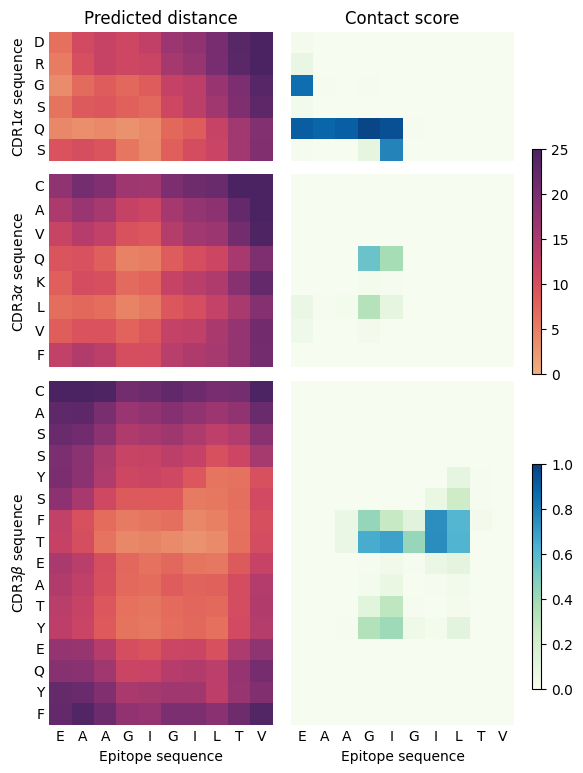

In [ ]:
#@title Display prediction results
import pickle

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

prediction_path = f'{result_dir}/predictions.pkl'
with open(prediction_path, 'rb') as f:
    predictions = pickle.load(f)

plot_data = predictions[0]

fig, axes = plt.subplots(3, 2, figsize=(6, 9), sharey='row', sharex='col', gridspec_kw={
                         'wspace': 0.08, 'hspace': 0.06, 'height_ratios': [0.6, 0.9, 1.6]})
epitope = plot_data['epitope']
cdr1_alpha = plot_data['cdr1.alpha']
cdr3_alpha = plot_data['cdr3.alpha']
cdr3_beta = plot_data['cdr3.beta']

sns.heatmap(plot_data['dist']['cdr1.alpha'],
            cmap='flare', vmin=0, vmax=25, ax=axes[0, 0], cbar=False)
axes[0, 0].set_xticks(np.arange(len(epitope))+0.5, labels=list(epitope))
axes[0, 0].set_yticks(np.arange(len(cdr1_alpha))+0.5,
                      labels=list(cdr1_alpha), rotation=0)
axes[0, 0].set_title(r'Predicted distance')
axes[0, 0].set_ylabel(r'CDR1$\alpha$ sequence')

sns.heatmap(plot_data['contact']['cdr1.alpha'],
            cmap='GnBu', vmin=0, vmax=1, ax=axes[0, 1], cbar=False)
axes[0, 1].set_xticks(np.arange(len(epitope))+0.5, labels=list(epitope))
axes[0, 1].set_yticks(np.arange(len(cdr1_alpha))+0.5,
                     labels=list(cdr1_alpha), rotation=0)
axes[0, 1].set_title(r'Contact score')

sns.heatmap(plot_data['dist']['cdr3.alpha'],
            cmap='flare', vmin=0, vmax=25, ax=axes[1, 0], cbar=False)
axes[1, 0].set_xticks(np.arange(len(epitope))+0.5, labels=list(epitope))
axes[1, 0].set_yticks(np.arange(len(cdr3_alpha))+0.5,
                      labels=list(cdr3_alpha), rotation=0)
axes[1, 0].set_ylabel(r'CDR3$\alpha$ sequence')

sns.heatmap(plot_data['contact']['cdr3.alpha'],
            cmap='GnBu', vmin=0, vmax=1, ax=axes[1, 1], cbar=False)
axes[1, 1].set_xticks(np.arange(len(epitope))+0.5, labels=list(epitope))
axes[1, 1].set_yticks(np.arange(len(cdr3_alpha))+0.5,
                      labels=list(cdr3_alpha), rotation=0)

sns.heatmap(plot_data['dist']['cdr3.beta'],
            cmap='flare', vmin=0, vmax=25, ax=axes[2, 0], cbar=False)
axes[2, 0].set_xticks(np.arange(len(epitope))+0.5, labels=list(epitope))
axes[2, 0].set_yticks(np.arange(len(cdr3_beta))+0.5,
                      labels=list(cdr3_beta), rotation=0)
axes[2, 0].set_xlabel('Epitope sequence')
axes[2, 0].set_ylabel(r'CDR3$\beta$ sequence')

sns.heatmap(plot_data['contact']['cdr3.beta'],
            cmap='GnBu', vmin=0, vmax=1, ax=axes[2, 1], cbar=False)
axes[2, 1].set_xticks(np.arange(len(epitope))+0.5, labels=list(epitope))
axes[2, 1].set_yticks(np.arange(len(cdr3_beta))+0.5,
                      labels=list(cdr3_beta), rotation=0)
axes[2, 1].set_xlabel('Epitope sequence')

axes[0, 0].tick_params(axis='both', which='both', length=0)
axes[0, 1].tick_params(axis='both', which='both', length=0)
axes[1, 0].tick_params(axis='both', which='both', length=0)
axes[1, 1].tick_params(axis='both', which='both', length=0)
axes[2, 0].tick_params(axis='both', which='both', length=0)
axes[2, 1].tick_params(axis='both', which='both', length=0)

# [left, bottom, width, height]
cbar_ax_1 = fig.add_axes([0.93, 0.5, 0.015, 0.25])
plt.colorbar(axes[0, 0].collections[0], cax=cbar_ax_1)

cbar_ax_2 = fig.add_axes([0.93, 0.15, 0.015, 0.25])
plt.colorbar(axes[0, 1].collections[0], cax=cbar_ax_2)

plt.show()